<a href="https://colab.research.google.com/github/mid998/machinelearning/blob/main/Michelle_Copy_of_Price_Prediction_using_LSTM_and_TA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from datetime import date
import math
import pandas_datareader as web

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error


In [ ]:
#import effective federal fund rate (EFFR) to merge with ticker
!pip install fredapi
from fredapi import Fred
fred = Fred(api_key='70c590444c9695cf6ed8b30bcc13f8a8')

EFFR_series = fred.get_series('EFFR')
UNRATE_series = fred.get_series('UNRATE')

#Check EFFR and UNRATE
EFFR = EFFR_series.to_frame()
EFFR.rename(columns={ EFFR.columns[0]: "EFFR" }, inplace = True)
EFFR.index.names = ['Date']
print(EFFR.head(10))
print(EFFR.tail(10))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
            EFFR
Date            
2000-07-03  7.03
2000-07-04   NaN
2000-07-05  6.52
2000-07-06  6.51
2000-07-07  6.42
2000-07-10  6.51
2000-07-11  6.39
2000-07-12  6.38
2000-07-13  6.50
2000-07-14  6.51
            EFFR
Date            
2022-11-22  3.83
2022-11-23  3.83
2022-11-24   NaN
2022-11-25  3.83
2022-11-28  3.83
2022-11-29  3.83
2022-11-30  3.83
2022-12-01  3.83
2022-12-02  3.83
2022-12-05  3.83


In [ ]:
EFFR.index.inferred_type == "datetime64"

True

In [ ]:
stock_ticker = 'AMZN'
start_day = '2010-01-01'
end_day = '2020-12-31'
start = pd.to_datetime([start_day]).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime([end_day]).astype(int)[0]//10**9 # convert to unix timestamp.
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock_ticker + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
data = pd.read_csv(url)
#data = web.get_data_yahoo('AMZN', start = datetime.datetime(2000, 1, 2), 
#                             end = date.today())
print(data.columns)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date',inplace=True)
data = data[['Adj Close']]
data.columns = ['Price']
data.head()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,Price
Date,
2010-01-04,6.6950
2010-01-05,6.7345
2010-01-06,6.6125
2010-01-07,6.5000
2010-01-08,6.6760


In [ ]:
data.index.inferred_type == "datetime64"

True

In [ ]:
from pickle import TRUE
#Merge EFFR with stock price
data.join(EFFR)

,Price,EFFR
Date,,
2010-01-04,6.695000,0.12
2010-01-05,6.734500,0.12
2010-01-06,6.612500,0.12
2010-01-07,6.500000,0.10
2010-01-08,6.676000,0.11
...,...,...
2020-12-23,159.263504,0.09
2020-12-24,158.634506,0.09
2020-12-28,164.197998,0.09


In [ ]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 2768 number of days in the dataset.


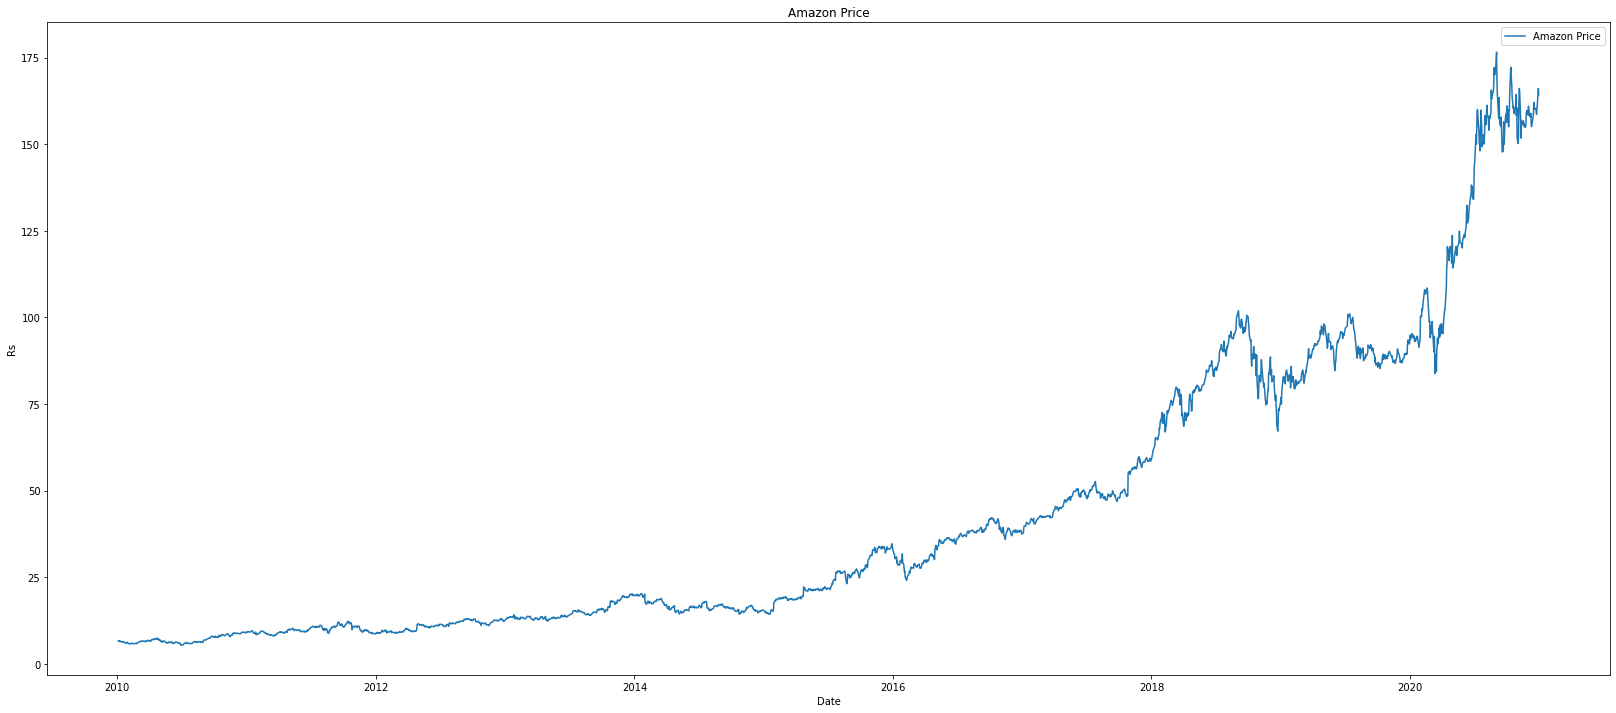

In [ ]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(data.index, data['Price'], label='Amazon Price')
plt.xlabel('Date')
plt.ylabel('Rs')
plt.title('Amazon Price')
plt.legend()
plt.show()

In [ ]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Price'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Price'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Price'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Price'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Price']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [ ]:
df = get_technical_indicators(data)
df = df.join(EFFR)

In [ ]:
df = df.dropna()
df.head()

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,EFFR
Date,,,,,,,,,,,,,
2010-02-02,5.9060,6.078357,6.328643,6.232816,6.149356,-0.083460,0.249620,6.827882,5.829404,5.953405,4.9060,1.590459,0.14
2010-02-03,5.9550,6.069714,6.293405,6.207598,6.118677,-0.088921,0.247539,6.788483,5.798326,5.954468,4.9550,1.600397,0.13
2010-02-04,5.7970,6.044429,6.248762,6.170940,6.068104,-0.102836,0.248547,6.745856,5.751668,5.849489,4.7970,1.567991,0.14
2010-02-05,5.8695,6.006143,6.213381,6.144431,6.036985,-0.107446,0.247059,6.707498,5.719264,5.862830,4.8695,1.582991,0.13
2010-02-08,5.8415,5.940429,6.182024,6.118155,6.006441,-0.111714,0.250625,6.683273,5.680774,5.848610,4.8415,1.577225,0.13


In [ ]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(30,20))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for {} - last {} days.'.format(stock_ticker,last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot

    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

<Figure size 1600x1000 with 0 Axes>

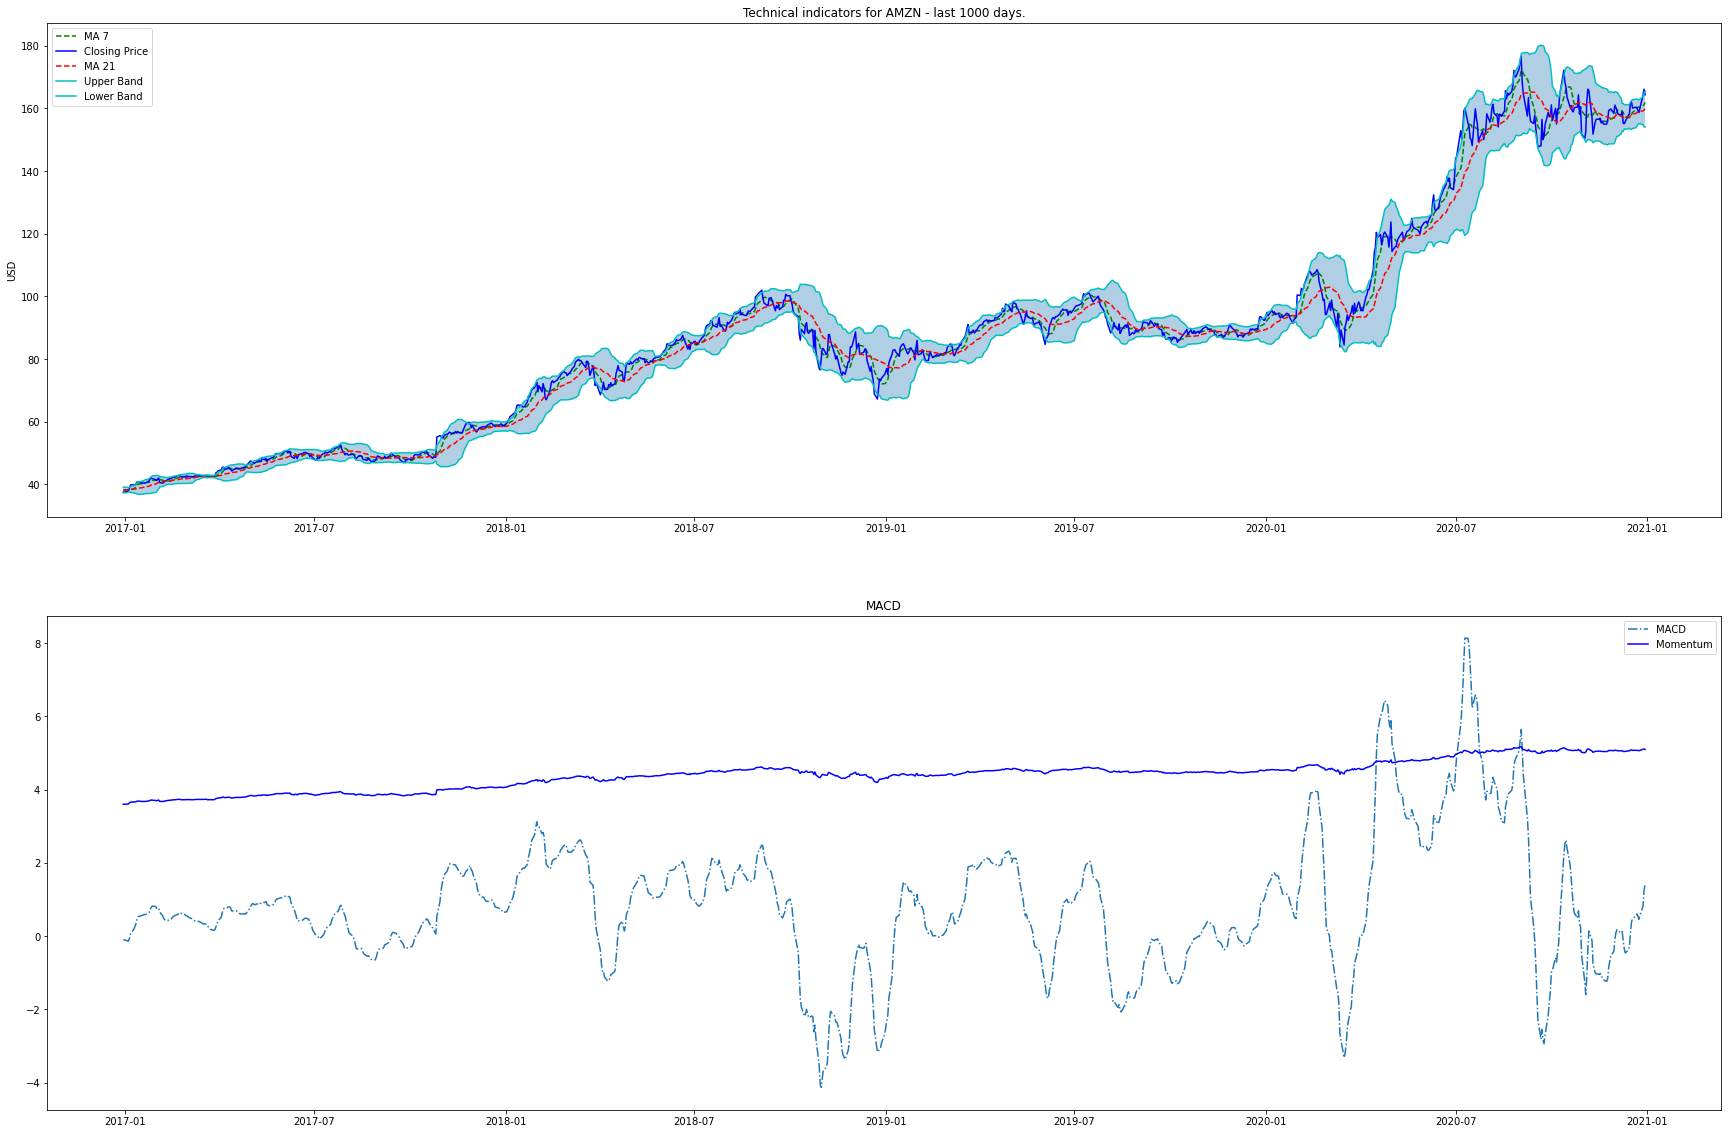

In [ ]:
plot_technical_indicators(df, 1000)

Text(0.5, 1.0, 'Params')

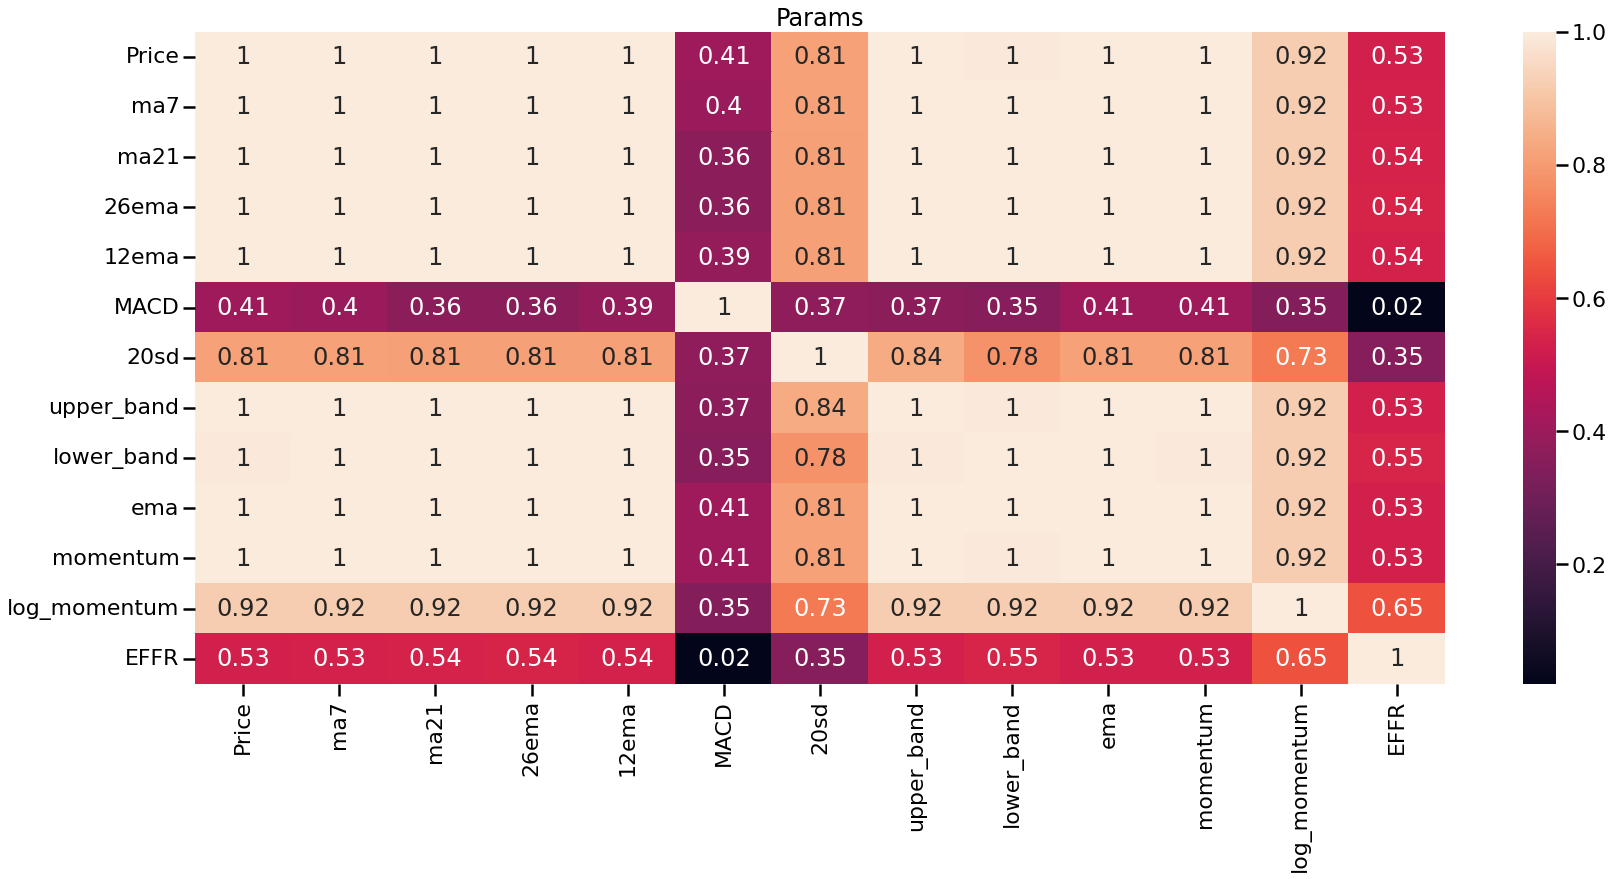

In [ ]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(df.corr(), annot = True).set_title('Params')


In [ ]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 2727 samples, and 13 features.


In [ ]:
df.columns

Index(['Price', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band',
       'lower_band', 'ema', 'momentum', 'log_momentum', 'EFFR'],
      dtype='object')

In [ ]:
df

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,EFFR
Date,,,,,,,,,,,,,
2010-02-02,5.906000,6.078357,6.328643,6.232816,6.149356,-0.083460,0.249620,6.827882,5.829404,5.953405,4.906000,1.590459,0.14
2010-02-03,5.955000,6.069714,6.293405,6.207598,6.118677,-0.088921,0.247539,6.788483,5.798326,5.954468,4.955000,1.600397,0.13
2010-02-04,5.797000,6.044429,6.248762,6.170940,6.068104,-0.102836,0.248547,6.745856,5.751668,5.849489,4.797000,1.567991,0.14
2010-02-05,5.869500,6.006143,6.213381,6.144431,6.036985,-0.107446,0.247059,6.707498,5.719264,5.862830,4.869500,1.582991,0.13
2010-02-08,5.841500,5.940429,6.182024,6.118155,6.006441,-0.111714,0.250625,6.683273,5.680774,5.848610,4.841500,1.577225,0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,159.263504,160.298431,158.799000,158.766449,159.317884,0.551435,2.010952,162.820903,154.777096,159.623937,158.263504,5.064261,0.09
2020-12-24,158.634506,160.352504,158.929071,158.756676,159.212749,0.456073,1.899520,162.728110,155.130032,158.964316,157.634506,5.060279,0.09
2020-12-28,164.197998,160.659646,159.164524,159.159737,159.979710,0.819974,2.220987,163.606497,154.722551,162.453437,163.197998,5.094964,0.09


In [ ]:
#print(df.index)
data_training = df[df.index < '2018-01-01'].copy()
#data_training = df[df.date < '2019-01-31'].copy()
data_training

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,EFFR
Date,,,,,,,,,,,,,
2010-02-02,5.906000,6.078357,6.328643,6.232816,6.149356,-0.083460,0.249620,6.827882,5.829404,5.953405,4.906000,1.590459,0.14
2010-02-03,5.955000,6.069714,6.293405,6.207598,6.118677,-0.088921,0.247539,6.788483,5.798326,5.954468,4.955000,1.600397,0.13
2010-02-04,5.797000,6.044429,6.248762,6.170940,6.068104,-0.102836,0.248547,6.745856,5.751668,5.849489,4.797000,1.567991,0.14
2010-02-05,5.869500,6.006143,6.213381,6.144431,6.036985,-0.107446,0.247059,6.707498,5.719264,5.862830,4.869500,1.582991,0.13
2010-02-08,5.841500,5.940429,6.182024,6.118155,6.006441,-0.111714,0.250625,6.683273,5.680774,5.848610,4.841500,1.577225,0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,58.417999,58.943571,58.513547,57.801693,58.597223,0.795531,0.807548,60.128644,56.898451,58.557693,57.417999,4.050358,1.42
2017-12-26,58.838001,58.961428,58.491547,57.878456,58.634266,0.755810,0.791179,60.073905,56.909190,58.744565,57.838001,4.057646,1.42
2017-12-27,59.112999,58.983714,58.459238,57.969904,58.707917,0.738014,0.748120,59.955479,56.962997,58.990188,58.112999,4.062389,1.42


In [ ]:
data_testing = df[df.index >= '2018-01-01'].copy()
data_testing

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,EFFR
Date,,,,,,,,,,,,,
2018-01-02,59.450500,58.905142,58.490095,58.198905,58.857414,0.658509,0.744374,59.978843,57.001347,59.205562,58.450500,4.068180,1.42
2018-01-03,60.209999,59.115428,58.589738,58.347875,59.065504,0.717629,0.827424,60.244585,56.934891,59.875187,59.209999,4.081090,1.42
2018-01-04,60.479500,59.409928,58.769833,58.505773,59.283042,0.777268,0.806291,60.382415,57.157251,60.278062,59.479500,4.085632,1.42
2018-01-05,61.457001,59.784071,58.978333,58.724383,59.617497,0.893114,0.906903,60.792138,57.164528,61.064021,60.457001,4.101932,1.42
2018-01-08,62.343498,60.245571,59.203381,58.992465,60.036882,1.044416,1.114862,61.433104,56.973657,61.917006,61.343498,4.116489,1.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,159.263504,160.298431,158.799000,158.766449,159.317884,0.551435,2.010952,162.820903,154.777096,159.623937,158.263504,5.064261,0.09
2020-12-24,158.634506,160.352504,158.929071,158.756676,159.212749,0.456073,1.899520,162.728110,155.130032,158.964316,157.634506,5.060279,0.09
2020-12-28,164.197998,160.659646,159.164524,159.159737,159.979710,0.819974,2.220987,163.606497,154.722551,162.453437,163.197998,5.094964,0.09


In [ ]:
scalar = MinMaxScaler()

data_training_scaled = scalar.fit_transform(data_training)
print(data_training_scaled.shape)
data_training_scaled

(1978, 13)


array([[0.00874708, 0.00979808, 0.00935652, ..., 0.00874708, 0.03943032,
        0.07246377],
       [0.00964846, 0.00963631, 0.00868759, ..., 0.00964846, 0.04327417,
        0.06521739],
       [0.00674197, 0.00916305, 0.00784012, ..., 0.00674197, 0.03074018,
        0.07246377],
       ...,
       [0.98751861, 1.        , 0.99896903, ..., 0.98751861, 0.99551035,
        1.        ],
       [0.99105057, 0.99940108, 0.99863004, ..., 0.99105057, 0.99678612,
        1.        ],
       [0.97575466, 0.9970067 , 0.99900066, ..., 0.97575466, 0.99123053,
        0.93478261]])

In [ ]:
X_train = []
y_train = []

In [ ]:
for i in range(60, data_training.shape[0]):
    X_train.append(data_training_scaled[i-60: i])
    y_train.append(data_training_scaled[i, 0])

In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((1918, 60, 13), (1918,))

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 13)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

In [ ]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            12800     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [ ]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
regressor.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
30/30 [==============================] - 33s 597ms/step - loss: 0.0269
Epoch 2/10
30/30 [==============================] - 9s 306ms/step - loss: 0.0058
Epoch 3/10
30/30 [==============================] - 10s 341ms/step - loss: 0.0057
Epoch 4/10
30/30 [==============================] - 9s 294ms/step - loss: 0.0049
Epoch 5/10
30/30 [==============================] - 9s 294ms/step - loss: 0.0044
Epoch 6/10
30/30 [==============================] - 9s 289ms/step - loss: 0.0044
Epoch 7/10
30/30 [==============================] - 9s 287ms/step - loss: 0.0040
Epoch 8/10
30/30 [==============================] - 9s 289ms/step - loss: 0.0035
Epoch 9/10
30/30 [==============================] - 9s 288ms/step - loss: 0.0043
Epoch 10/10
30/30 [==============================] - 9s 286ms/step - loss: 0.0038


In [ ]:
past_60 = data_training.tail(60)

dt = past_60.append(data_testing, ignore_index = True)
dt

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,EFFR
0,48.272499,47.778285,48.376357,48.268808,48.028022,-0.240786,0.787616,49.951588,46.801125,48.144084,47.272499,3.855929,1.16
1,49.042500,48.080071,48.407428,48.326118,48.184095,-0.142023,0.800939,50.009306,46.805551,48.743028,48.042500,3.872086,1.16
2,49.479000,48.356571,48.431500,48.411517,48.383311,-0.028205,0.826006,50.083512,46.779488,49.233676,48.479000,3.881131,1.16
3,49.360001,48.788286,48.513238,48.559826,48.685383,0.125557,0.876961,50.267159,46.759317,49.388076,48.360001,3.878673,1.16
4,49.750000,49.044071,48.542809,48.647987,48.849170,0.201183,0.908660,50.360129,46.725490,49.629359,48.750000,3.886705,1.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,159.263504,160.298431,158.799000,158.766449,159.317884,0.551435,2.010952,162.820903,154.777096,159.623937,158.263504,5.064261,0.09
805,158.634506,160.352504,158.929071,158.756676,159.212749,0.456073,1.899520,162.728110,155.130032,158.964316,157.634506,5.060279,0.09
806,164.197998,160.659646,159.164524,159.159737,159.979710,0.819974,2.220987,163.606497,154.722551,162.453437,163.197998,5.094964,0.09
807,166.100006,161.273361,159.466096,159.673831,160.921294,1.247464,2.687785,164.841665,154.090527,164.884483,165.100006,5.106551,0.09


In [ ]:
inputs = scalar.fit_transform(dt)
print(inputs.shape)
inputs

(809, 13)


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.64730290e-01],
       [6.00156683e-03, 2.42757221e-03, 2.65643912e-04, ...,
        6.00156683e-03, 1.23138775e-02, 4.64730290e-01],
       [9.40374932e-03, 4.65174662e-03, 4.71441702e-04, ...,
        9.40374932e-03, 1.92070395e-02, 4.64730290e-01],
       ...,
       [9.03550293e-01, 9.08020629e-01, 9.47177468e-01, ...,
        9.03550293e-01, 9.44298026e-01, 2.07468880e-02],
       [9.18374986e-01, 9.12957369e-01, 9.49755740e-01, ...,
        9.18374986e-01, 9.53128912e-01, 2.07468880e-02],
       [9.04286833e-01, 9.17795267e-01, 9.52153861e-01, ...,
        9.04286833e-01, 9.44739198e-01, 2.07468880e-02]])

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((749, 60, 13), (749,))

In [ ]:
y_pred_epoch_10 = regressor.predict(X_test)

24/24 [==============================] - 2s 57ms/step


In [ ]:
#y_pred
mse_epoch_10 = math.sqrt(mean_squared_error(y_test, y_pred_epoch_10))
print('Epochs 10 Test Score: %.3f RMSE' % (mse_epoch_10))

Epochs 10 Test Score: 0.106 RMSE


In [ ]:
# epoch 25
regressor.fit(X_train, y_train, epochs=25, batch_size = 64)
y_pred_epoch_25 = regressor.predict(X_test)
mse_epoch_25 = math.sqrt(mean_squared_error(y_test, y_pred_epoch_25))
print('Epochs 25 Test Score: %.3f RMSE' % (mse_epoch_25))

Epoch 1/25
30/30 [==============================] - 10s 324ms/step - loss: 0.0032
Epoch 2/25
30/30 [==============================] - 10s 348ms/step - loss: 0.0034
Epoch 3/25
30/30 [==============================] - 9s 289ms/step - loss: 0.0038
Epoch 4/25
30/30 [==============================] - 9s 292ms/step - loss: 0.0028
Epoch 5/25
30/30 [==============================] - 9s 289ms/step - loss: 0.0025
Epoch 6/25
30/30 [==============================] - 9s 288ms/step - loss: 0.0033
Epoch 7/25
30/30 [==============================] - 9s 286ms/step - loss: 0.0032
Epoch 8/25
30/30 [==============================] - 9s 291ms/step - loss: 0.0027
Epoch 9/25
30/30 [==============================] - 9s 294ms/step - loss: 0.0026
Epoch 10/25
30/30 [==============================] - 9s 286ms/step - loss: 0.0026
Epoch 11/25
30/30 [==============================] - 9s 294ms/step - loss: 0.0027
Epoch 12/25
30/30 [==============================] - 9s 292ms/step - loss: 0.0026
Epoch 13/25
30/30 [====

In [ ]:
# epoch 25
regressor.fit(X_train, y_train, epochs=50, batch_size = 64)
y_pred_epoch_50 = regressor.predict(X_test)
mse_epoch_50 = math.sqrt(mean_squared_error(y_test, y_pred_epoch_50))
print('Epochs 50 Test Score: %.3f RMSE' % (mse_epoch_50))

Epoch 1/50
30/30 [==============================] - 9s 293ms/step - loss: 0.0019
Epoch 2/50
30/30 [==============================] - 9s 295ms/step - loss: 0.0020
Epoch 3/50
30/30 [==============================] - 9s 289ms/step - loss: 0.0020
Epoch 4/50
30/30 [==============================] - 10s 336ms/step - loss: 0.0020
Epoch 5/50
30/30 [==============================] - 9s 292ms/step - loss: 0.0019
Epoch 6/50
30/30 [==============================] - 9s 295ms/step - loss: 0.0019
Epoch 7/50
30/30 [==============================] - 9s 294ms/step - loss: 0.0018
Epoch 8/50
30/30 [==============================] - 9s 294ms/step - loss: 0.0017
Epoch 9/50
30/30 [==============================] - 9s 293ms/step - loss: 0.0020
Epoch 10/50
30/30 [==============================] - 9s 291ms/step - loss: 0.0019
Epoch 11/50
30/30 [==============================] - 9s 291ms/step - loss: 0.0019
Epoch 12/50
30/30 [==============================] - 9s 294ms/step - loss: 0.0021
Epoch 13/50
30/30 [=====

In [ ]:
scale = 1/scalar.scale_[0]

In [ ]:
y_pred_epoch_10 = y_pred_epoch_10*scale
y_pred_epoch_25 = y_pred_epoch_25*scale
y_pred_epoch_50 = y_pred_epoch_50*scale
y_test = y_test*scale

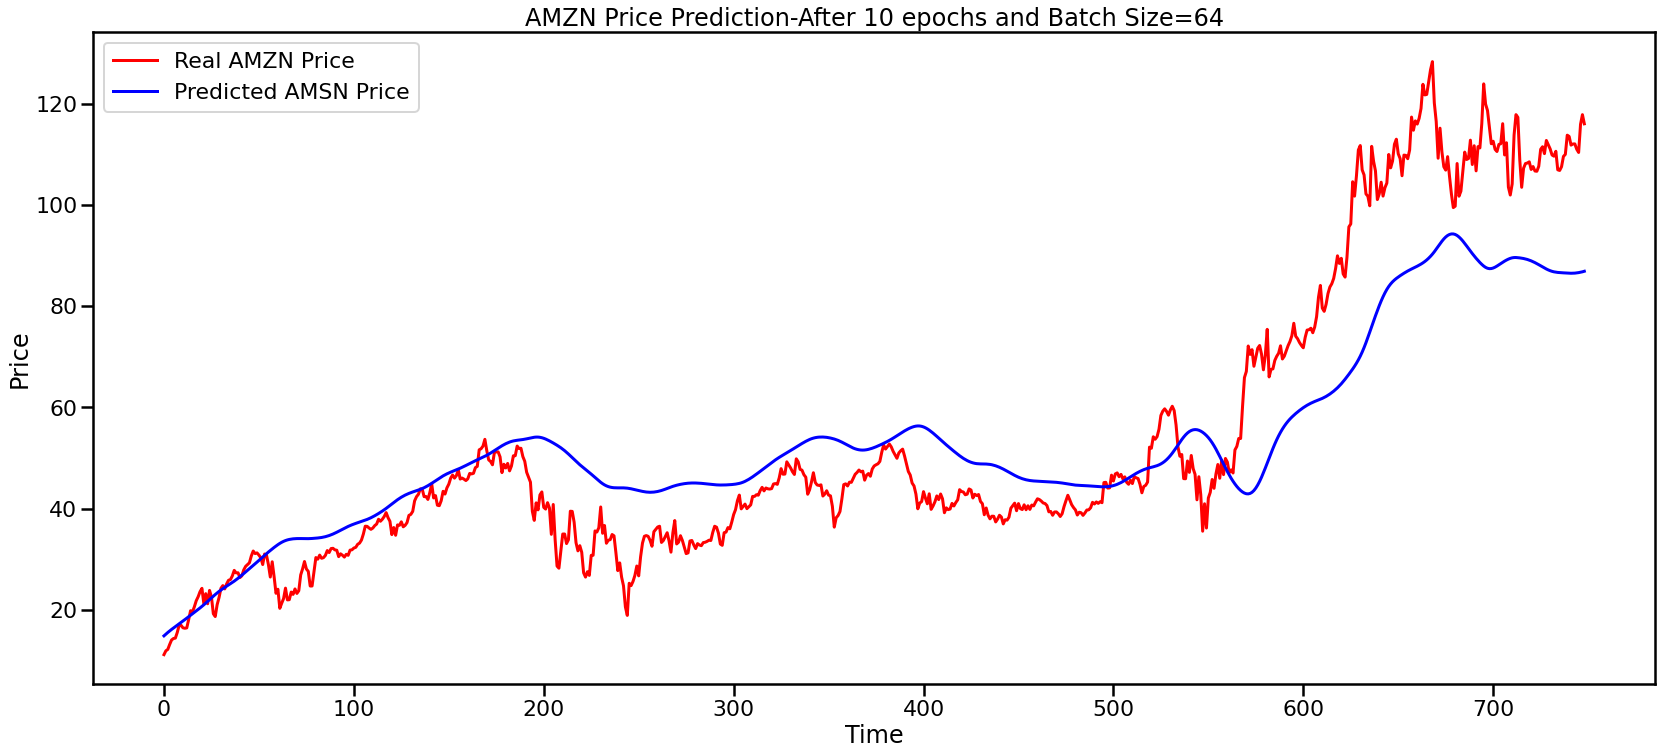

In [ ]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real AMZN Price')
plt.plot(y_pred_epoch_10, color = 'blue', label = 'Predicted AMSN Price')
plt.title('AMZN Price Prediction-After 10 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

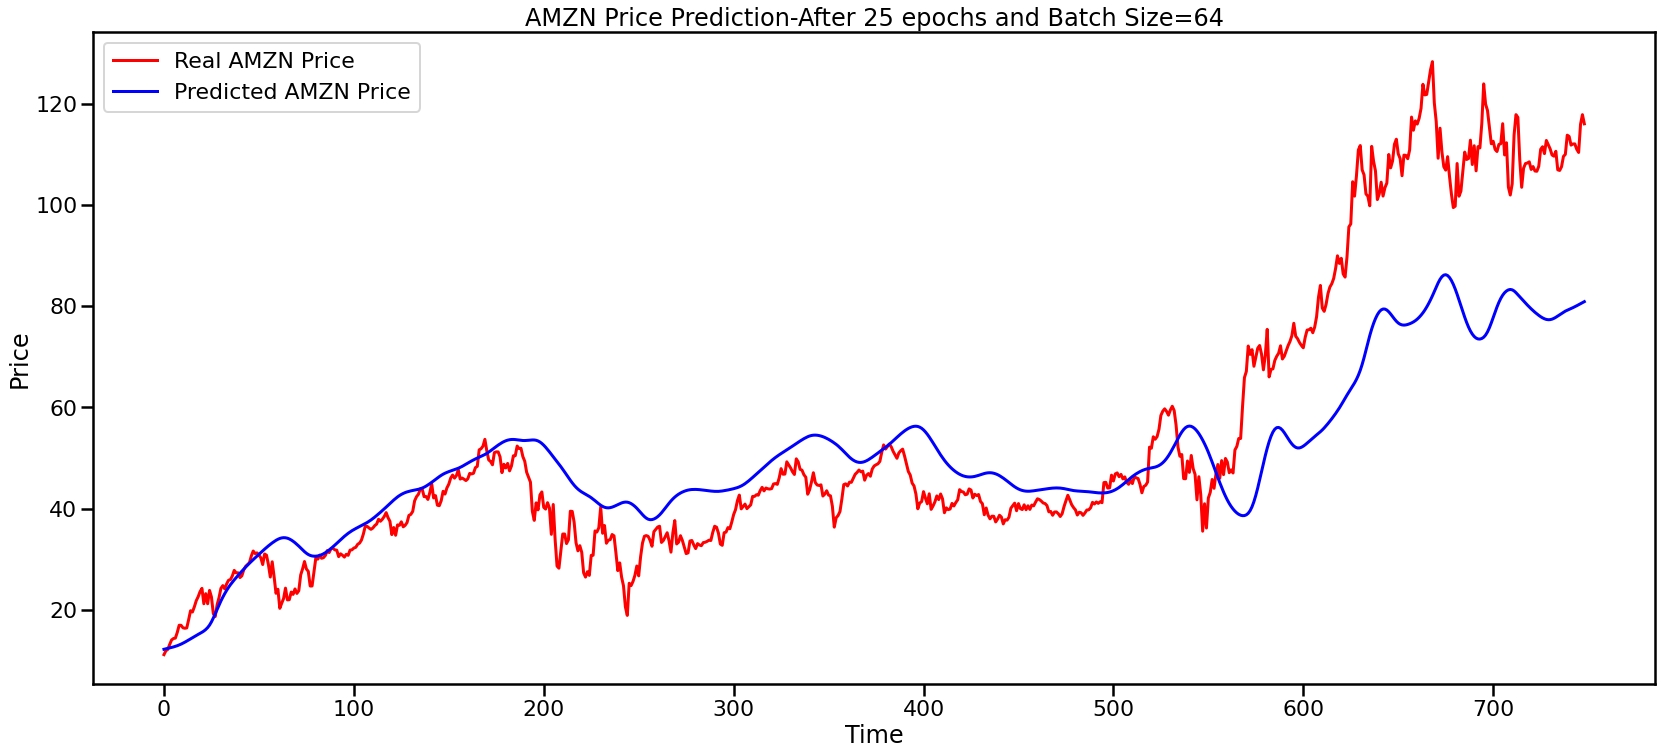

In [ ]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real AMZN Price')
plt.plot(y_pred_epoch_25, color = 'blue', label = 'Predicted AMZN Price')
plt.title('AMZN Price Prediction-After 25 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

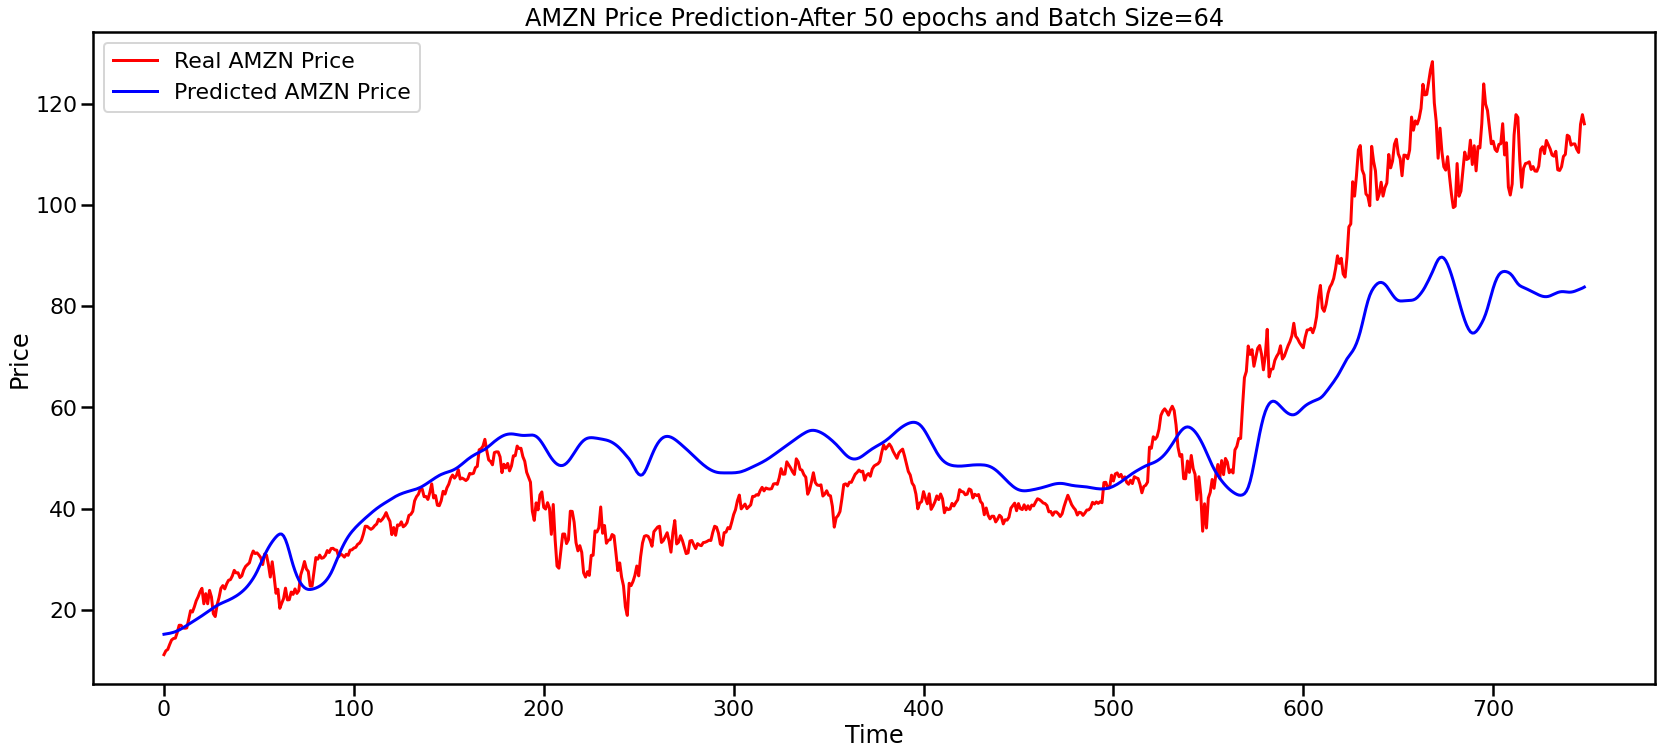

In [ ]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real AMZN Price')
plt.plot(y_pred_epoch_50, color = 'blue', label = 'Predicted AMZN Price')
plt.title('AMZN Price Prediction-After 50 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
print('LSTM epoch 10 mse  %.3f ' % (mse_epoch_10))
print('LSTM epoch 25 mse  %.3f ' % (mse_epoch_25))
print('LSTM epoch 50 mse  %.3f ' % (mse_epoch_50))

LSTM epoch 10 mse  0.106 
LSTM epoch 25 mse  0.125 
LSTM epoch 50 mse  0.118 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
#title = "LSTM learning curve"
#plot_learning_curve(
#    regressor, title, X_test, y_test.ravel(), axes=data[:, 0], ylim=(0.7, 1.01), cv=10, n_jobs=4
#)

In [ ]:
############### Roya - Trying Arima


In [ ]:
import numpy as np
import pandas as pd
from numpy import bincount, linspace, mean, std, arange, squeeze
import itertools, time, datetime
from scipy.stats import randint
from pandas import set_option
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import graphviz 
from graphviz import Source
from IPython.display import SVG
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, precision_score, recall_score
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
stock_ticker = 'AMZN'
start_day = '2010-01-01'
end_day = '2020-12-31'
start = pd.to_datetime([start_day]).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime([end_day]).astype(int)[0]//10**9 # convert to unix timestamp.
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock_ticker + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
data = pd.read_csv(url)
#data = web.get_data_yahoo('AMZN', start = datetime.datetime(2000, 1, 2), 
#                             end = date.today())
print(data.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [ ]:
dataOrg = data
dataOrg.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,6.8125,6.8305,6.6570,6.6950,6.6950,151998000
1,2010-01-05,6.6715,6.7740,6.5905,6.7345,6.7345,177038000
2,2010-01-06,6.7300,6.7365,6.5825,6.6125,6.6125,143576000
3,2010-01-07,6.6005,6.6160,6.4400,6.5000,6.5000,220604000
4,2010-01-08,6.5280,6.6840,6.4515,6.6760,6.6760,196610000


In [ ]:
dataOrg[['Date', 'Close']].head(3)

,Date,Close
0,2010-01-04,6.6950
1,2010-01-05,6.7345
2,2010-01-06,6.6125


In [ ]:
print('There are {} number of days in the dataset.'.format(dataOrg.shape[0]))

There are 2768 number of days in the dataset.


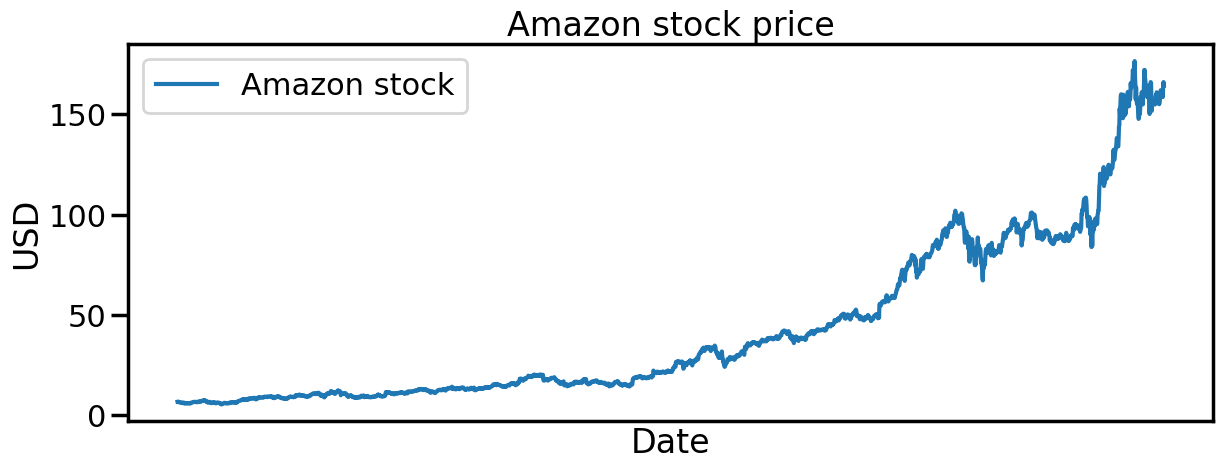

In [ ]:
import matplotlib.dates as mdates
startdate = '2015-01-01'
enddate= '2020-12-31'
cuttoffdate = '2016-04-20'
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataOrg['Date'], dataOrg['Close'], label='Amazon stock')
#plt.vlines(pd.to_datetime(cuttoffdate), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
ax = plt.gca()
# change tick frequency, format and rotation
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
#plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Amazon stock price')
plt.legend()
plt.show()



In [ ]:
# ANALYSIS OF TIME SERIES USING FOURIER TRANSFORM
data_FT = dataOrg[['Date', 'Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

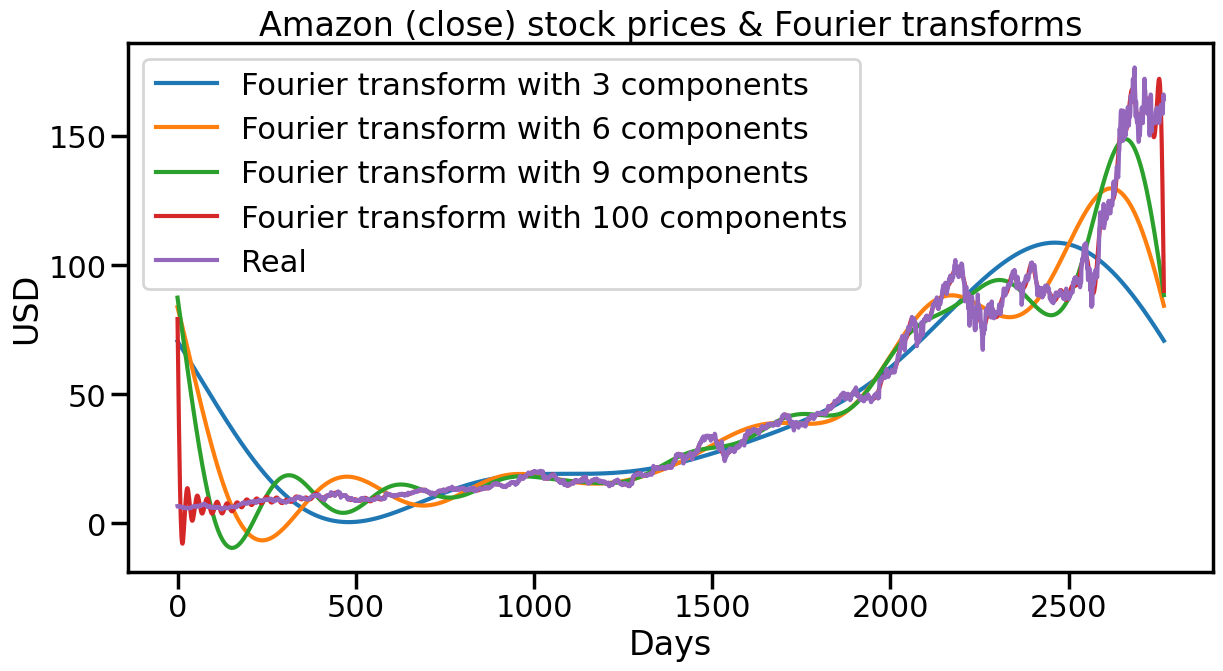

In [ ]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Amazon (close) stock prices & Fourier transforms')
plt.legend()
plt.show()


In [ ]:
# Based on above diagram we can see the spectral component of 100 is closest to the real price so we will move ahead ith 100

In [ ]:
def get_fourier(dataset):
    data_FT = dataset[['Date', 'Close']]
    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    close_fft = np.fft.ifft(close_fft)
    close_fft
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_list_m10= np.copy(fft_list); fft_list_m10[100:-100]=0
    dataset['Fourier'] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))
    #dataset['absolute'] = dataset['Fourier'].apply(lambda x: np.abs(x))
    return dataset
     

In [ ]:
dataset_TI_df = get_fourier(dataOrg)
dataset_TI_df.head(30)

,Date,Open,High,Low,Close,Adj Close,Volume,Fourier
0,2010-01-04,6.8125,6.8305,6.6570,6.6950,6.6950,151998000,6.6950
1,2010-01-05,6.6715,6.7740,6.5905,6.7345,6.7345,177038000,6.7345
2,2010-01-06,6.7300,6.7365,6.5825,6.6125,6.6125,143576000,6.6125
3,2010-01-07,6.6005,6.6160,6.4400,6.5000,6.5000,220604000,6.5000
4,2010-01-08,6.5280,6.6840,6.4515,6.6760,6.6760,196610000,6.6760
5,2010-01-11,6.6310,6.6400,6.4605,6.5155,6.5155,175588000,6.5155
6,2010-01-12,6.4495,6.4910,6.3275,6.3675,6.3675,181926000,6.3675
7,2010-01-13,6.3950,6.4855,6.2875,6.4555,6.4555,214464000,6.4555
8,2010-01-14,6.4570,6.5190,6.3200,6.3675,6.3675,195498000,6.3675
9,2010-01-15,6.4590,6.4825,6.3530,6.3570,6.3570,307530000,6.3570


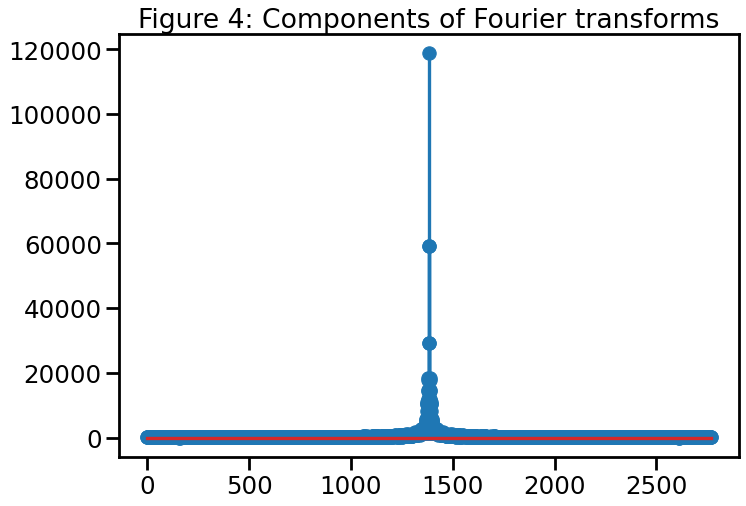

In [ ]:

from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [ ]:
# Arima

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2767
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4456.893
Method:                       css-mle   S.D. of innovations              1.211
Date:                Tue, 06 Dec 2022   AIC                           8927.787
Time:                        23:54:41   BIC                           8969.266
Sample:                             1   HQIC                          8942.768
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0569      0.021      2.757      0.006       0.016       0.097
ar.L1.D.Close    -0.0591      0.019     -3.108      0.002      -0.096      -0.022
ar.L2.D.Close     0.0124      0.019     

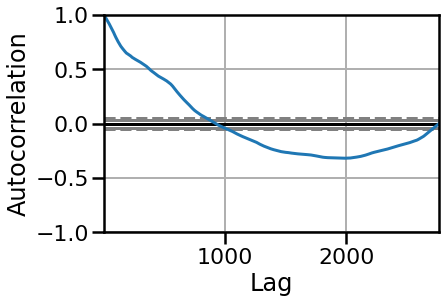

<Figure size 800x560 with 0 Axes>

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()
     

In [ ]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

dataset_TI_df['ARIMA'] = pd.DataFrame(predictions)

In [ ]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 6.191


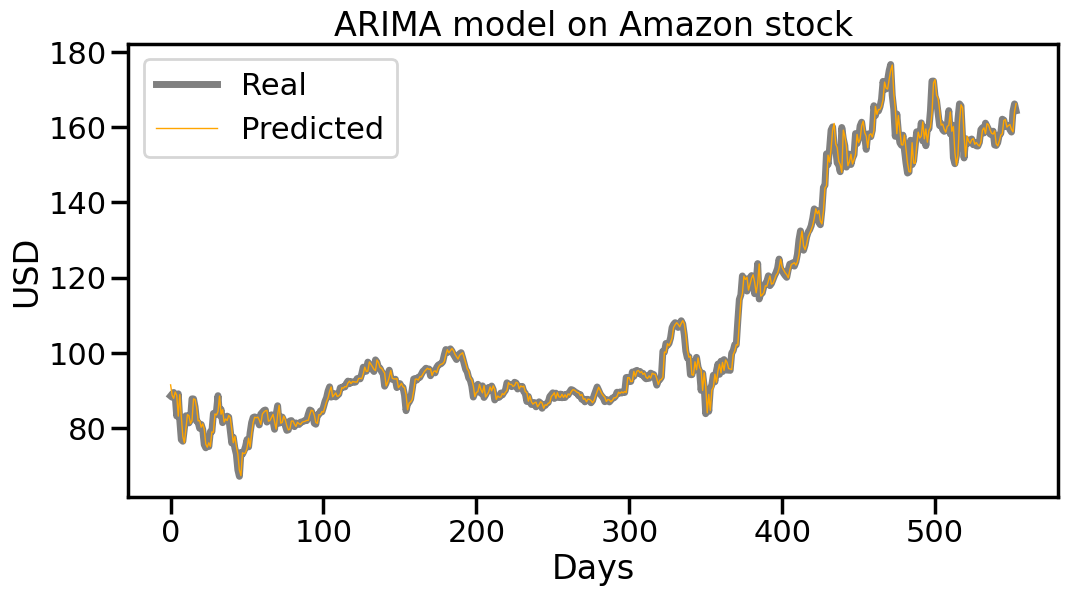

In [ ]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, color='gray', linewidth=5,label='Real')
plt.plot(predictions, color='orange', linewidth=1, label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('ARIMA model on Amazon stock')
plt.legend()
plt.show()
     

In [ ]:
#As we can see from Figure 5 ARIMA gives a very good approximation of the real stock price